In [1]:
%matplotlib inline

import numpy as np

from sklearn_theano.feature_extraction import fetch_overfeat_weights_and_biases

import menpo.io as mio
from menpo.visualize import visualize_images

from alaborticcv2015.deepconvkernel.pretrained import PreTrainedLDCN

# Pre-Trained LDCN 

Obtain OverFeat filters:

In [2]:
weights, _ = fetch_overfeat_weights_and_biases(large_network=True)

In [3]:
filters = [np.asarray(w) for w in weights]

Number and shape of the filters per layer:

In [4]:
for j, w in enumerate(filters):
    print 'Layer:', j,  '\t # of filters:', w.shape[0], '\t shape:', w.shape[1:] 

Layer: 0 	 # of filters: 96 	 shape: (3, 7, 7)
Layer: 1 	 # of filters: 256 	 shape: (96, 7, 7)
Layer: 2 	 # of filters: 512 	 shape: (256, 3, 3)
Layer: 3 	 # of filters: 512 	 shape: (512, 3, 3)
Layer: 4 	 # of filters: 1024 	 shape: (512, 3, 3)
Layer: 5 	 # of filters: 1024 	 shape: (1024, 3, 3)
Layer: 6 	 # of filters: 4096 	 shape: (1024, 5, 5)
Layer: 7 	 # of filters: 4096 	 shape: (4096, 1, 1)
Layer: 8 	 # of filters: 1000 	 shape: (4096, 1, 1)


Build a Pre-Trained LinDeepConvNet with the filters of the first 2 layers:

In [5]:
net = PreTrainedLDCN(filters[:2])

In [6]:
print '# of layers:', net.n_layers
print '# of filters:', net.n_filters
print '# of filters per layer:', net.n_filters_layer
print 'filters shape:', net.filters_shape

# of layers: 2
# of filters: 352
# of filters per layer: [96, 256]
filters shape: (7, 7)


Visualize the previous filters using the previous LinDeepConvNet:

In [7]:
filters = net.filters_spatial()

First layer spatial filters:

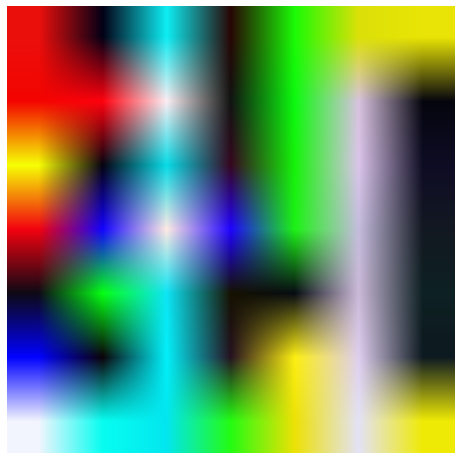

In [8]:
visualize_images(filters[0])

Second layer spatial filters:

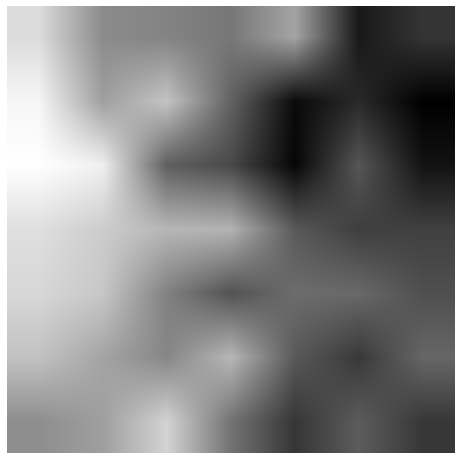

In [9]:
visualize_images(filters[1])

We can also visualize the previous filters on the frequency domain:

In [10]:
filters_frequecy = net.filters_frequency(ext_shape=(50, 50))

First layer filters in the frequency domain:

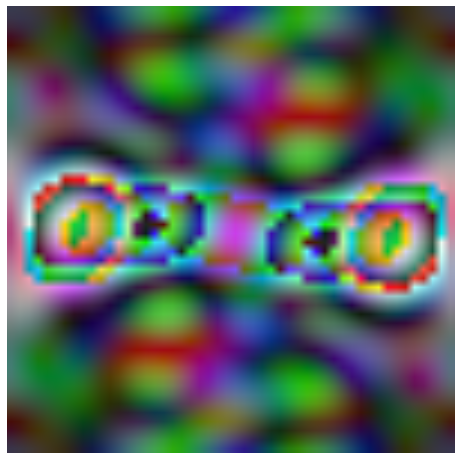

In [11]:
visualize_images(filters_frequecy[0])

Second layer filters in the frequency domain:

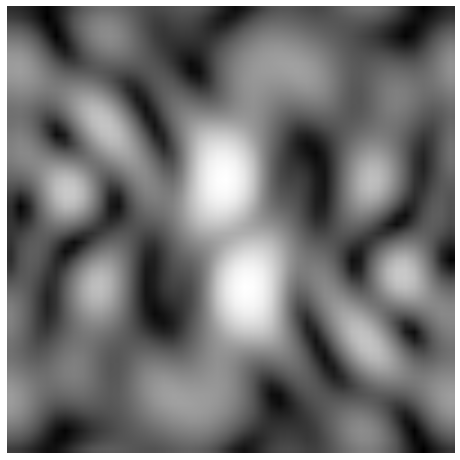

In [12]:
visualize_images(filters_frequecy[1])

Visualize Deep Convolutional Kernels:

In [13]:
kernels = net.kernels_spatial(ext_shape=(50, 50))

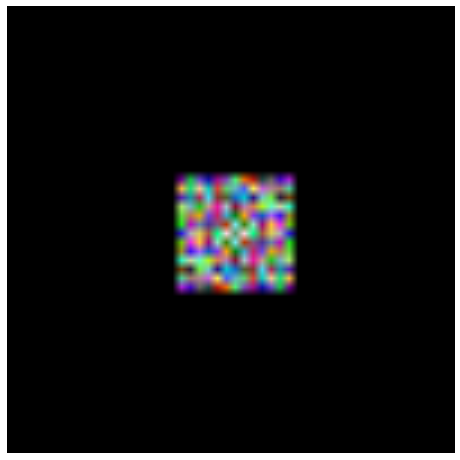

In [14]:
visualize_images(kernels)

In [15]:
kernels = net.kernels_frequency(ext_shape=(50, 50))

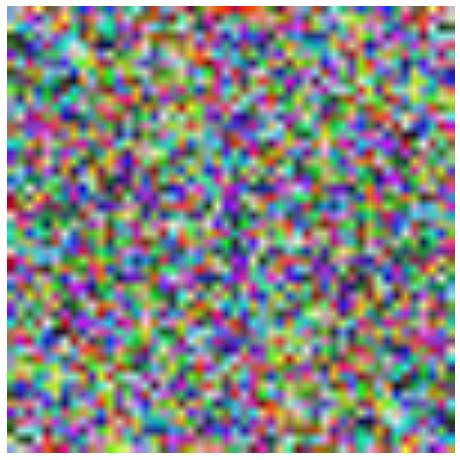

In [16]:
visualize_images(kernels)

Load images:

In [17]:
images = []
for i in mio.import_images('~/PhD/DataBases/faces/lfpw/trainset/', verbose=True, 
                           max_images=10):
    i.crop_to_landmarks_proportion_inplace(1)
    i = i.rescale_landmarks_to_diagonal_range(100)
    images.append(i)

- Loading 10 assets: [====================] 100%

Compute network features:

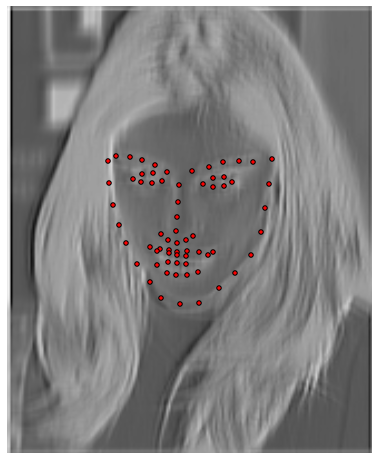

In [18]:
net.compute_network_response(images[0], layer=0).view_widget()

Compute deep convolutional kernel features:

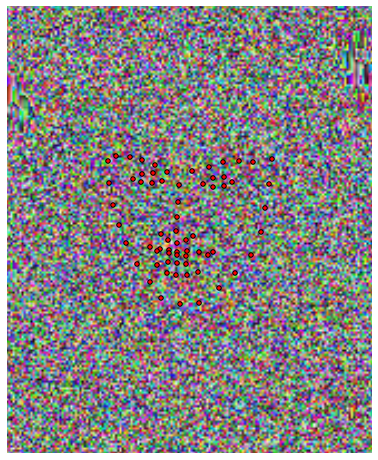

In [19]:
net.compute_kernel_response(images[0]).view_widget()

In [4]:
first_layer_weights = [Image(w) for w in weights[0]]

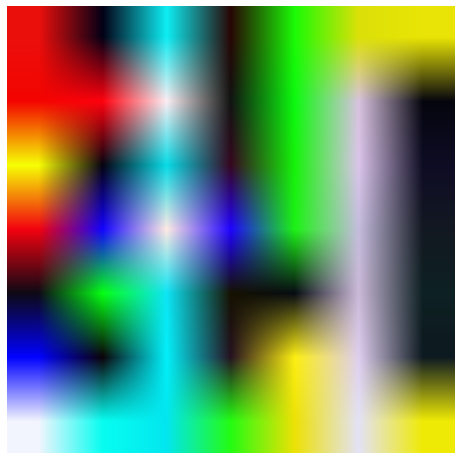

In [5]:
visualize_images(first_layer_weights)

In [ ]:
%timeit fft2(weights[0])

In [44]:
%timeit pad(weights[0], ext_shape=(100, 100))

100 loops, best of 3: 5.63 ms per loop


In [ ]:
filters = fftshift(fft2(pad(weights[1], ext_shape=(100, 100))))

In [ ]:
filters.shape

In [ ]:
first_layer_weights = [Image(np.abs(w)) for w in filters]

In [ ]:
visualize_images(first_layer_weights)

In [ ]:
np.std(weights[0][0])

In [6]:
from __future__ import division
from functools import wraps
import numpy as np
from menpo.image import Image

from menpo.feature.base import rebuild_feature_image


def ndconvolution(wrapped):

    @wraps(wrapped)
    def wrapper(image, filter, *args, **kwargs):
        if not isinstance(image, np.ndarray) and not isinstance(filter, np.ndarray):
            # Both image and filter are menpo images
            feature = wrapped(image.pixels, filter.pixels, *args, **kwargs)
            return rebuild_feature_image(image, feature)
        elif not isinstance(image, np.ndarray):
            # Image is menpo image
            feature = wrapped(image.pixels, filter, *args, **kwargs)
            return rebuild_feature_image(image, feature)
        elif not isinstance(filter, np.ndarray):
            # filter is menpo image
            return wrapped(image, filter, *args, **kwargs)
        else:
            return wrapped(image, filter, *args, **kwargs)
    return wrapper

In [7]:
@ndconvolution
def fft_convolve2d(x, f, mode='same', boundary='constant'):
    r"""
    Performs fast 2d convolution in the frequency domain.

    Parameters
    ----------
    x : ``(channels, height, width)`` `ndarray`
        Image.
    f : ``(channels, height, width)`` `ndarray`
        Filter.
    mode : str {`full`, `same`, `valid`}, optional
        Determines the shape of the resulting convolution.
    boundary: str {`constant`, `symmetric`}, optional
        Determines how the image is padded.
    Returns
    -------
    c: ``(channels, height, width)`` `ndarray`
        Result of convolving each image channel with its corresponding
        filter channel.
    """
    # extended shape
    x_shape = np.asarray(x.shape[-2:])
    f_shape = np.asarray(f.shape[-2:])
    ext_shape = x_shape + f_shape - 1

    # extend image and filter
    ext_x = pad(x, ext_shape, boundary=boundary)
    ext_f = pad(f, ext_shape)

    # compute ffts of extended image and extended filter
    fft_ext_x = fft2(ext_x)
    fft_ext_f = fft2(ext_f)

    # compute extended convolution in Fourier domain
    fft_ext_c = fft_ext_f * fft_ext_x

    # compute ifft of extended convolution
    ext_c = np.real(ifftshift(ifft2(fft_ext_c), axes=(-2, -1)))

    if mode is 'full':
        return ext_c
    elif mode is 'same':
        return crop(ext_c, x_shape)
    elif mode is 'valid':
        return crop(ext_c, x_shape - f_shape + 1)
    else:
        raise ValueError(
            "mode={}, is not supported. The only supported "
            "modes are: 'full', 'same' and 'valid'.".format(mode))
        

@ndconvolution
def fft_convolve2d_sum(x, f, mode='same', boundary='constant', axis=0):
    return np.sum(fft_convolve2d(x, f, mode=mode, boundary=boundary), axis=axis)

In [8]:
images = []
for i in mio.import_images('~/PhD/DataBases/faces/lfpw/trainset/', verbose=True, 
                           max_images=10):
    
    i.crop_to_landmarks_proportion_inplace(1)
    i = i.rescale_landmarks_to_diagonal_range(100)
    labeller(i, 'PTS', ibug_face_66)
#     if i.n_channels == 3:
#         i = i.as_greyscale(mode='average')
    images.append(i)

- Loading 10 assets: [====================] 100%

In [9]:
feature_image = fft_convolve2d_sum(images[0], weights[0], axis=1)

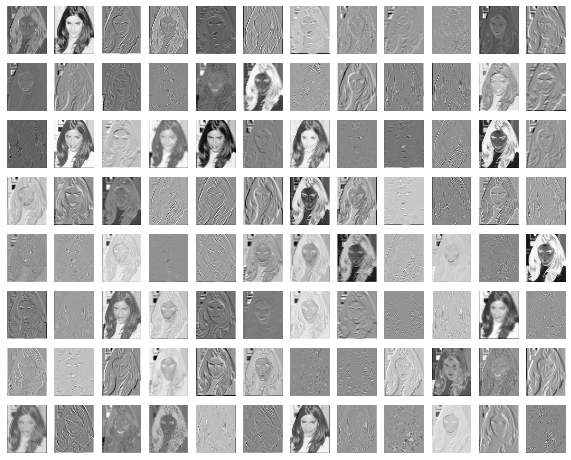

In [12]:
feature_image.view()

In [13]:
feature_image2 = fft_convolve2d_sum(feature_image, weights[1][:30], axis=1)

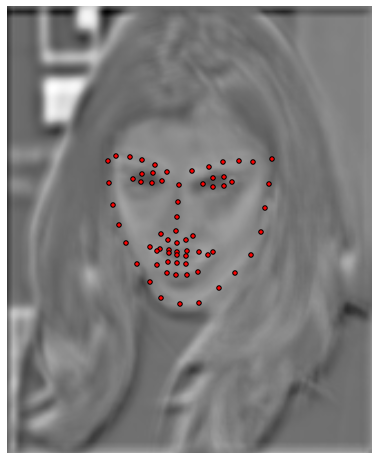

In [15]:
feature_image2.view_widget()

In [ ]:
filters0 = fftshift(fft2(pad(weights[0], ext_shape=(100, 100))))

In [ ]:
dck0 = 0
for f0 in filters0:
    dck0 += f0.conj() * f0 

In [ ]:
Image(np.real(dck)).view_widget()

In [ ]:
filters1 = fftshift(fft2(pad(weights[1][:20], ext_shape=(100, 100))))

In [ ]:
dck1 = 0
for f1 in filters1:
    dck1 += f1.conj() * f1 

In [ ]:
Image(np.real(dck1)).view_widget()